# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch cell line 1 to 6.   


In [219]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 16:26:05.698907
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [220]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [221]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [222]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [223]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=6
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 6 = MCF.7


## Data Load

In [224]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [225]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 16:26:08.834516
Load RCI values...
Num RCI: 11060
Example RCI: [('ENSG00000000003', 1.72696), ('ENSG00000000419', 1.15523), ('ENSG00000000457', -1.34317)]
Load genes...
2022-12-29 16:26:08.873276
Load sequence...
2022-12-29 16:26:18.854691
Num IDs: 6031
Example IDs: [('ENSG00000197530', 'ENST00000355826.10'), ('ENSG00000157916', 'ENST00000605895.6'), ('ENSG00000158286', 'ENST00000377939.5'), ('ENSG00000171680', 'ENST00000675694.1')]
Count 2225 ones out of 6031 labels.
Example labels: [0, 0, 0, 0]
Num counts: 6031
Example sequence: [34, 135, 26, 102, 150, 85, 83, 74, 40, 158, 119, 219, 106, 166, 151, 90, 102, 151, 91, 107, 169, 162, 134, 22, 85, 83, 75, 43, 170, 165, 148, 79, 59, 233, 164, 143, 59, 233, 163, 138, 38, 150, 86, 87, 89, 99, 139, 42, 167, 155, 108, 175, 187, 235, 169, 163, 138, 40, 158, 118, 214, 85, 83, 76, 48, 190, 248, 222, 117, 212, 78, 54, 216, 95, 122, 230, 150, 88, 95, 123, 236, 174, 182, 215, 91, 106, 167, 156, 110, 184, 224, 126, 248, 223, 123, 233, 163,

## Model

In [226]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [227]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 16:26:18.892831
COMPILE
Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_112 (Embedding)   (None, 3997, 4)           1028      
                                                                 
 conv1d_112 (Conv1D)         (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_99  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_223 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [228]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 16:26:19.183104
2022-12-29 16:26:19.184432
splitting
Fold 1
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (4768, 3997) (4768, 1)
Valid sizes (1263, 3997) (1263, 1)
Train set ones/size 1713 / 4768
Valid set ones/size 512 / 1263
BUILD MODEL
COMPILE
FIT
2022-12-29 16:26:20.678873
Epoch 1/5
149/149 [==============================] - 2s 8ms/step - loss: 0.6369 - accuracy: 0.6426 - val_loss: 0.6492 - val_accuracy: 0.6271
Epoch 2/5
149/149 [==============================] - 1s 7ms/step - loss: 0.6115 - accuracy: 0.6525 - val_loss: 0.6505 - val_accuracy: 0.6334
Epoch 3/5
149/149 [==============================] - 1s 7ms/step - loss: 0.6057 - accuracy: 0.6604 - val_loss: 0.6452 - val_accuracy: 0.6302
Epoch 4/5
149/149 [==============================] - 1s 7ms/step - loss: 0.6020 - accuracy: 0.6703 - val_loss: 0.6483 - val_accuracy: 0.6382
Epoch 5/5
149/149 [==============================] - 1s 7ms/step - loss: 0.5978 - accuracy: 0.6718 - val_loss: 0.6417 - val_accuracy: 

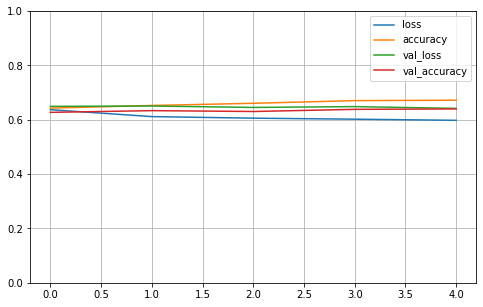

Compute valiation accuracy
2022-12-29 16:26:27.000309
Range of scores: 0.0948365 to 0.7716673
Predicted zeros and ones 1022 241
Accuracy: 63.97% Precision: 61.83% Recall: 29.10% F1: 39.58%
2022-12-29 16:26:27.218364
Fold 2
Training example
[167 155 106 ...   0   0   0]
Train sizes (4753, 3997) (4753, 1)
Valid sizes (1278, 3997) (1278, 1)
Train set ones/size 1713 / 4753
Valid set ones/size 512 / 1278
BUILD MODEL
COMPILE
FIT
2022-12-29 16:26:28.657924
Epoch 1/5
149/149 [==============================] - 2s 9ms/step - loss: 0.6427 - accuracy: 0.6390 - val_loss: 0.6497 - val_accuracy: 0.6009
Epoch 2/5
149/149 [==============================] - 1s 8ms/step - loss: 0.6127 - accuracy: 0.6625 - val_loss: 0.6454 - val_accuracy: 0.5962
Epoch 3/5
149/149 [==============================] - 1s 7ms/step - loss: 0.6074 - accuracy: 0.6722 - val_loss: 0.6413 - val_accuracy: 0.6025
Epoch 4/5
149/149 [==============================] - 1s 8ms/step - loss: 0.6019 - accuracy: 0.6773 - val_loss: 0.6450 - val

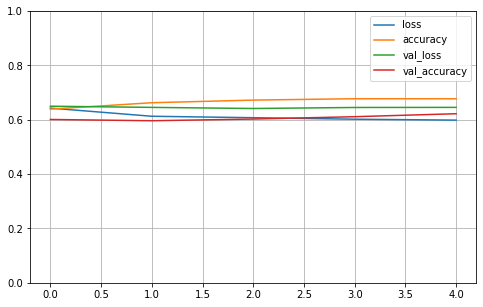

Compute valiation accuracy
2022-12-29 16:26:39.721522
Range of scores: 0.09651247 to 0.72018224
Predicted zeros and ones 1115 163
Accuracy: 62.21% Precision: 58.90% Recall: 18.75% F1: 28.44%
2022-12-29 16:26:39.949784
Fold 3
Training example
[167 155 106 ...   0   0   0]
Train sizes (4839, 3997) (4839, 1)
Valid sizes (1192, 3997) (1192, 1)
Train set ones/size 1780 / 4839
Valid set ones/size 445 / 1192
BUILD MODEL
COMPILE
FIT
2022-12-29 16:26:41.443955
Epoch 1/5
152/152 [==============================] - 2s 9ms/step - loss: 0.6482 - accuracy: 0.6328 - val_loss: 0.6222 - val_accuracy: 0.6309
Epoch 2/5
152/152 [==============================] - 1s 7ms/step - loss: 0.6213 - accuracy: 0.6412 - val_loss: 0.6072 - val_accuracy: 0.6644
Epoch 3/5
152/152 [==============================] - 1s 7ms/step - loss: 0.6168 - accuracy: 0.6524 - val_loss: 0.6040 - val_accuracy: 0.6703
Epoch 4/5
152/152 [==============================] - 1s 7ms/step - loss: 0.6121 - accuracy: 0.6572 - val_loss: 0.5982 - v

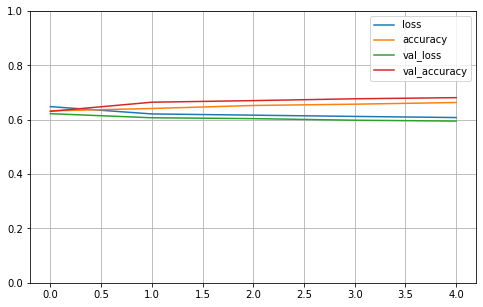

Compute valiation accuracy
2022-12-29 16:26:48.005772
Range of scores: 0.10986736 to 0.73739153
Predicted zeros and ones 981 211
Accuracy: 68.12% Precision: 65.40% Recall: 31.01% F1: 42.07%
2022-12-29 16:26:48.263091
Fold 4
Training example
[167 155 106 ...   0   0   0]
Train sizes (4899, 3997) (4899, 1)
Valid sizes (1132, 3997) (1132, 1)
Train set ones/size 1835 / 4899
Valid set ones/size 390 / 1132
BUILD MODEL
COMPILE
FIT
2022-12-29 16:26:49.721308
Epoch 1/5
154/154 [==============================] - 2s 9ms/step - loss: 0.6524 - accuracy: 0.6216 - val_loss: 0.6055 - val_accuracy: 0.6608
Epoch 2/5
154/154 [==============================] - 1s 7ms/step - loss: 0.6249 - accuracy: 0.6450 - val_loss: 0.5967 - val_accuracy: 0.6731
Epoch 3/5
154/154 [==============================] - 1s 7ms/step - loss: 0.6181 - accuracy: 0.6499 - val_loss: 0.5967 - val_accuracy: 0.6714
Epoch 4/5
154/154 [==============================] - 1s 7ms/step - loss: 0.6137 - accuracy: 0.6548 - val_loss: 0.5985 - va

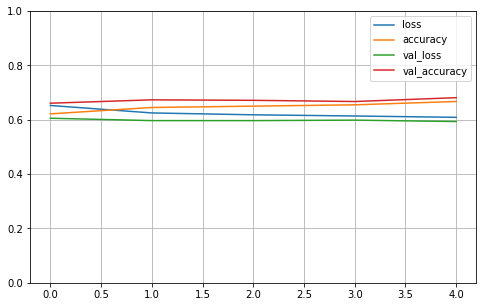

Compute valiation accuracy
2022-12-29 16:27:00.759752
Range of scores: 0.11594781 to 0.8061349
Predicted zeros and ones 883 249
Accuracy: 68.11% Precision: 55.82% Recall: 35.64% F1: 43.51%
2022-12-29 16:27:01.013796
Fold 5
Training example
[167 155 106 ...   0   0   0]
Train sizes (4865, 3997) (4865, 1)
Valid sizes (1166, 3997) (1166, 1)
Train set ones/size 1859 / 4865
Valid set ones/size 366 / 1166
BUILD MODEL
COMPILE
FIT
2022-12-29 16:27:02.477754
Epoch 1/5
153/153 [==============================] - 2s 9ms/step - loss: 0.6527 - accuracy: 0.6197 - val_loss: 0.5933 - val_accuracy: 0.6827
Epoch 2/5
153/153 [==============================] - 1s 7ms/step - loss: 0.6258 - accuracy: 0.6327 - val_loss: 0.5927 - val_accuracy: 0.6895
Epoch 3/5
153/153 [==============================] - 1s 7ms/step - loss: 0.6200 - accuracy: 0.6462 - val_loss: 0.5901 - val_accuracy: 0.6930
Epoch 4/5
153/153 [==============================] - 1s 7ms/step - loss: 0.6173 - accuracy: 0.6530 - val_loss: 0.5947 - val

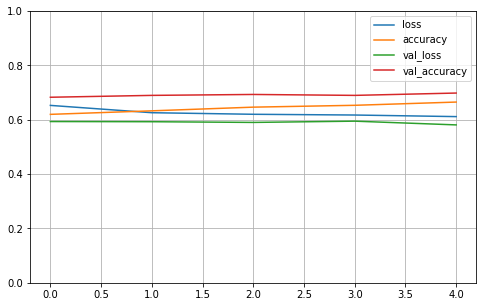

Compute valiation accuracy
2022-12-29 16:27:09.503993
Range of scores: 0.09632216 to 0.7873758
Predicted zeros and ones 840 326
Accuracy: 69.81% Precision: 52.15% Recall: 46.45% F1: 49.13%
2022-12-29 16:27:09.755074

Cross validation 5 folds 5 epochs
 accuracy mean 66.44% +/- 2.86
 precision mean 58.82% +/- 4.60
 recall mean 32.19% +/- 9.02
 F1 mean 40.55% +/- 6.81
2022-12-29 16:27:09.758873


In [229]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())